In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import gc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## 读入数据

In [3]:
train_df = pd.read_csv('../input/train.csv', index_col=0)
test_df = pd.read_csv('../input/test.csv', index_col=0)

In [4]:
train_df.shape[0], test_df.shape[0]

(76518, 51012)

## 特征工程(简单)

In [5]:
label = 'Target'

In [6]:
ori_all_feats = [col for col in train_df.columns if col != 'Target']

In [7]:
ori_cat_feats = [
    'Marital status',
    'Application mode',
    'Application order',
    'Course',
    'Daytime/evening attendance',
    'Previous qualification',
    'Nacionality',
    'Mother\'s qualification',
    'Father\'s qualification',
    'Mother\'s occupation',
    'Father\'s occupation',
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'International',
]

ori_num_feats = [
    'Previous qualification (grade)',
    'Admission grade',
    'Age at enrollment',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate',
    'Inflation rate',
    'GDP',
]

In [8]:
len(ori_all_feats), len(ori_cat_feats), len(ori_num_feats)

(36, 18, 18)

In [9]:
com_df = pd.concat([train_df, test_df], axis=0, ignore_index=False)

In [10]:
special_char = ["'", '/', ' ']
def normalize_feature_name(name):
    for c in special_char:
        name = name.replace(c, '_')
    name = name.replace('(', '').replace(')', '')
    return name

In [11]:
ori_all_feats = [normalize_feature_name(col) for col in ori_all_feats]
ori_cat_feats = [normalize_feature_name(col) for col in ori_cat_feats]
ori_num_feats = [normalize_feature_name(col) for col in ori_num_feats]

In [12]:
com_df.columns = com_df.columns.map(normalize_feature_name)

In [13]:
for col in ori_cat_feats:
    com_df[col] = LabelEncoder().fit_transform(com_df[col])

label2code = {
    'Graduate': 0,
    'Enrolled': 1,
    'Dropout': 2,
}

code2label = {v: v for k, v in label2code.items()}
com_df['Target'] = com_df['Target'].map(label2code)

In [14]:
train_df = com_df.loc[train_df.index].copy()
test_df = com_df.loc[test_df.index].copy()

In [15]:
train_df['Target'] = train_df['Target'].astype('int')

In [16]:
del com_df
gc.collect()

147

## 建模

### 数据集划分

In [17]:
trn_idx, val_idx = train_test_split(train_df.index, test_size=0.2, random_state=42)

In [18]:
len(trn_idx), len(val_idx)

(61214, 15304)

### lgb

In [19]:
trn_data = lgb.Dataset(train_df.loc[trn_idx, ori_all_feats], train_df.loc[trn_idx, label], categorical_feature=ori_cat_feats)
val_data = lgb.Dataset(train_df.loc[val_idx, ori_all_feats], train_df.loc[val_idx, label], categorical_feature=ori_cat_feats)

In [20]:
params = {
    'num_threads': 8,
    'learning_rate': 0.01,
    'objective': 'multiclass',
    'num_class': 3,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'metric': 'multi_error',
    'early_stopping_rounds': 400,
}

In [21]:
model = lgb.train(params, trn_data, 10000, valid_sets=val_data, callbacks=[lgb.log_evaluation(200)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 61214, number of used features: 36
[LightGBM] [Info] Start training from score -0.746287
[LightGBM] [Info] Start training from score -1.635907
[LightGBM] [Info] Start training from score -1.105333
Training until validation scores don't improve for 400 rounds
[200]	valid_0's multi_error: 0.17185
[400]	valid_0's multi_error: 0.167603
[600]	valid_0's multi_error: 0.16597
[800]	valid_0's multi_error: 0.166427
[1000]	valid_0's multi_error: 0.165447
[1200]	valid_0's multi_error: 0.165316
[1400]	valid_0's multi_error: 0.16499
Early stopping, best iteration is:
[1065]	valid_0's multi_error: 0.164467


In [22]:
oof = model.predict(train_df.loc[val_idx, ori_all_feats], num_iteration=model.best_iteration)

In [23]:
accuracy_score(train_df.loc[val_idx, label], oof.argmax(axis=-1))

0.8355331939362258

### NN

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### 网络搭建

In [78]:
class SimpleClassificationNet(nn.Module):
    def __init__(self, embedding_sizes, num_numeric_features, output_size, hidden_layers):
        '''
        embedding_sizes: [(num_cat1, emb_size1), ...]
        num_numeric_features: integer
        output_size: integer
        hidden_layers: list of integer
        '''
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_cat, size) for num_cat, size in embedding_sizes
        ])
        num_embeddings_out = sum(e.embedding_dim for e in self.embeddings)
        
        self.fc_layers = nn.Sequential()
        input_size = num_numeric_features + num_embeddings_out
        for i, hidden_size in enumerate(hidden_layers):
            self.fc_layers.add_module(f'fc{i}', nn.Linear(input_size, hidden_size))
            self.fc_layers.add_module(f'relu{i}', nn.ReLU())
            input_size = hidden_size
        
        self.output_layer = nn.Linear(input_size, output_size)
    
    def forward(self, x_numeric, x_categorical):
        embeddings = [embedding(cat) for embedding, cat in zip(self.embeddings, x_categorical)]
        x_embedding = torch.cat(embeddings, 1)
        x = torch.cat((x_embedding, x_numeric), 1)
        x = self.fc_layers(x)
        x = self.output_layer(x)
        return x

In [26]:
embedding_sizes = [ (train_df[col].max() + 1, 4) for col in ori_cat_feats]

In [27]:
embedding_sizes

[(6, 4),
 (24, 4),
 (8, 4),
 (23, 4),
 (2, 4),
 (22, 4),
 (19, 4),
 (37, 4),
 (41, 4),
 (45, 4),
 (58, 4),
 (2, 4),
 (2, 4),
 (2, 4),
 (2, 4),
 (2, 4),
 (2, 4),
 (2, 4)]

In [28]:
num_numeric_features = len(ori_num_feats)

output_size = 3    # 三分类

hidden_layers = [32, 16]    # 两层隐藏层

model = SimpleClassificationNet(embedding_sizes, num_numeric_features, output_size, hidden_layers)

In [29]:
# 取一部分数据做测试

batch_size = 8
x_numeric = torch.tensor(train_df[ori_num_feats].values[:batch_size], dtype=torch.float32)
x_categorical = torch.tensor(train_df[ori_cat_feats].values[:batch_size].transpose(1, 0), dtype=torch.long)

In [30]:
x_numeric.size(), x_categorical.size()

(torch.Size([8, 18]), torch.Size([18, 8]))

In [31]:
output = model(x_numeric, x_categorical)

In [32]:
output

tensor([[-0.9355,  0.6953,  0.3426],
        [-1.1224,  0.5347,  0.2520],
        [-1.4353,  0.7745,  0.4648],
        [-1.0731,  0.7390,  0.3499],
        [-1.1119,  0.7090,  0.3302],
        [-1.2747,  0.2756,  0.2537],
        [-1.0745,  0.6497,  0.3320],
        [-0.9979,  0.7599,  0.3909]], grad_fn=<AddmmBackward0>)

#### dataloader

In [33]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [34]:
class AcademicDataset(Dataset):
    def __init__(self, train_df, numeric_feats, categorical_feats, trn_idx, val_idx, mode):
        target_idx = trn_idx if mode == 'train' else val_idx
        self.numeric_data = train_df.loc[target_idx, numeric_feats].values
        self.categorical_data = train_df.loc[target_idx, categorical_feats].values
        self.target = train_df.loc[target_idx, 'Target'].values
        
    
    def __len__(self):
        return self.numeric_data.shape[0]
    
    def __getitem__(self, i):
        return {
            'x_numeric': self.numeric_data[i],
            'x_categorical': self.categorical_data[i],
            'y': self.target[i],
        }

In [35]:
train_data = AcademicDataset(
    train_df, 
    ori_num_feats, 
    ori_cat_feats,
    trn_idx,
    val_idx,
    mode='train',
)

In [36]:
val_data = AcademicDataset(
    train_df, 
    ori_num_feats, 
    ori_cat_feats,
    trn_idx,
    val_idx,
    mode='val',
)

In [37]:
batch_size = 1024

In [46]:
def data_collator(features):
    batch = {}
    batch['x_numeric'] = torch.tensor([f['x_numeric'] for f in features], dtype=torch.float32)
    
    x_categorical = np.vstack([f['x_categorical'] for f in features]).transpose(1, 0)
    batch['x_categorical'] = torch.tensor(x_categorical, dtype=torch.long)
    
    batch['y'] = torch.tensor([f['y'] for f in features], dtype=torch.long)
    
    return batch

In [47]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=data_collator)

In [48]:
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=data_collator)

#### 训练

In [79]:
model = SimpleClassificationNet(embedding_sizes, num_numeric_features, output_size, hidden_layers)

In [80]:
# 设置device，优先使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleClassificationNet(
  (embeddings): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(24, 4)
    (2): Embedding(8, 4)
    (3): Embedding(23, 4)
    (4): Embedding(2, 4)
    (5): Embedding(22, 4)
    (6): Embedding(19, 4)
    (7): Embedding(37, 4)
    (8): Embedding(41, 4)
    (9): Embedding(45, 4)
    (10): Embedding(58, 4)
    (11): Embedding(2, 4)
    (12): Embedding(2, 4)
    (13): Embedding(2, 4)
    (14): Embedding(2, 4)
    (15): Embedding(2, 4)
    (16): Embedding(2, 4)
    (17): Embedding(2, 4)
  )
  (fc_layers): Sequential(
    (fc0): Linear(in_features=90, out_features=32, bias=True)
    (relu0): ReLU()
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (relu1): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=3, bias=True)
)

In [43]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 分类问题常用的交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
# 设置训练的epochs
epochs = 200
train_loss = []
val_acc = []
for epoch in range(epochs):
    model.train()  # 设置模型为训练模式
    total_loss = 0
    for batch in train_loader:
        x_numeric = batch['x_numeric']
        x_categorical = batch['x_categorical']
        targets = batch['y']
        
        x_numeric = x_numeric.to(device)
        x_categorical = [x.to(device) for x in x_categorical]
        targets = targets.to(device)

        optimizer.zero_grad()  # 清空过往梯度
        outputs = model(x_numeric, x_categorical)  # 前向传播，获取输出
        loss = criterion(outputs, targets)  # 计算损失
        loss.backward()  # 反向传播，计算梯度
        optimizer.step()  # 根据梯度更新网络参数

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")
    train_loss.append(total_loss/len(train_loader))
    
    # 验证阶段，我们将计算并打印验证集上的准确率
    model.eval()  # 设置模型为评估模式
    all_label = []
    all_pred = []
    with torch.no_grad():
        for batch in val_loader:
            x_numeric = batch['x_numeric']
            x_categorical = batch['x_categorical']
            targets = batch['y']
            all_label.append(targets.numpy())

            x_numeric = x_numeric.to(device)
            x_categorical = [x.to(device) for x in x_categorical]
            outputs = model(x_numeric, x_categorical)
            
            outputs = outputs.detach().cpu().numpy()
            all_pred.append(outputs.argmax(axis=-1))

    all_label = np.concatenate(all_label)
    all_pred = np.concatenate(all_pred)

    acc = accuracy_score(all_label, all_pred)
    val_acc.append(acc)

    print(f"Val Acc: {acc}\n")

Epoch 1/200, Loss: 0.8990719646215439
Val Acc: 0.711578672242551

Epoch 2/200, Loss: 0.6185300568739573
Val Acc: 0.7635912179822268

Epoch 3/200, Loss: 0.5344246377547582
Val Acc: 0.7952169367485624

Epoch 4/200, Loss: 0.5018701995412509
Val Acc: 0.8082854155776268

Epoch 5/200, Loss: 0.49097086091836295
Val Acc: 0.8120752744380554

Epoch 6/200, Loss: 0.4831300228834152
Val Acc: 0.8120099320439101

Epoch 7/200, Loss: 0.48058765282233556
Val Acc: 0.8141008886565604

Epoch 8/200, Loss: 0.4775271366039912
Val Acc: 0.8146889702038683

Epoch 9/200, Loss: 0.47509700804948807
Val Acc: 0.8169759539989545

Epoch 10/200, Loss: 0.47472557226816814
Val Acc: 0.8173680083638265

Epoch 11/200, Loss: 0.4721707637111346
Val Acc: 0.8191975953998955

Epoch 12/200, Loss: 0.470527687172095
Val Acc: 0.8208964976476738

Epoch 13/200, Loss: 0.4701800172527631
Val Acc: 0.8193936225823314

Epoch 14/200, Loss: 0.4668114612499873
Val Acc: 0.8222033455305803

Epoch 15/200, Loss: 0.4670111358165741
Val Acc: 0.82259

Epoch 121/200, Loss: 0.4390380437175433
Val Acc: 0.8284108729743858

Epoch 122/200, Loss: 0.43976950893799466
Val Acc: 0.8296523784631469

Epoch 123/200, Loss: 0.44072428395350777
Val Acc: 0.8287375849451124

Epoch 124/200, Loss: 0.4406506881117821
Val Acc: 0.8314166231050706

Epoch 125/200, Loss: 0.44096287737290063
Val Acc: 0.8302404600104548

Epoch 126/200, Loss: 0.4414292598764102
Val Acc: 0.830893883951908

Epoch 127/200, Loss: 0.43966300586859386
Val Acc: 0.828672242550967

Epoch 128/200, Loss: 0.43938057621320087
Val Acc: 0.8299790904338735

Epoch 129/200, Loss: 0.4396275187532107
Val Acc: 0.8298484056455828

Epoch 130/200, Loss: 0.4390144641200701
Val Acc: 0.8286069001568217

Epoch 131/200, Loss: 0.44066202292839685
Val Acc: 0.8297830632514376

Epoch 132/200, Loss: 0.43907616237799324
Val Acc: 0.8293256664924202

Epoch 133/200, Loss: 0.4391248012582461
Val Acc: 0.8302404600104548

Epoch 134/200, Loss: 0.4389959082007408
Val Acc: 0.8305671719811814

Epoch 135/200, Loss: 0.440226

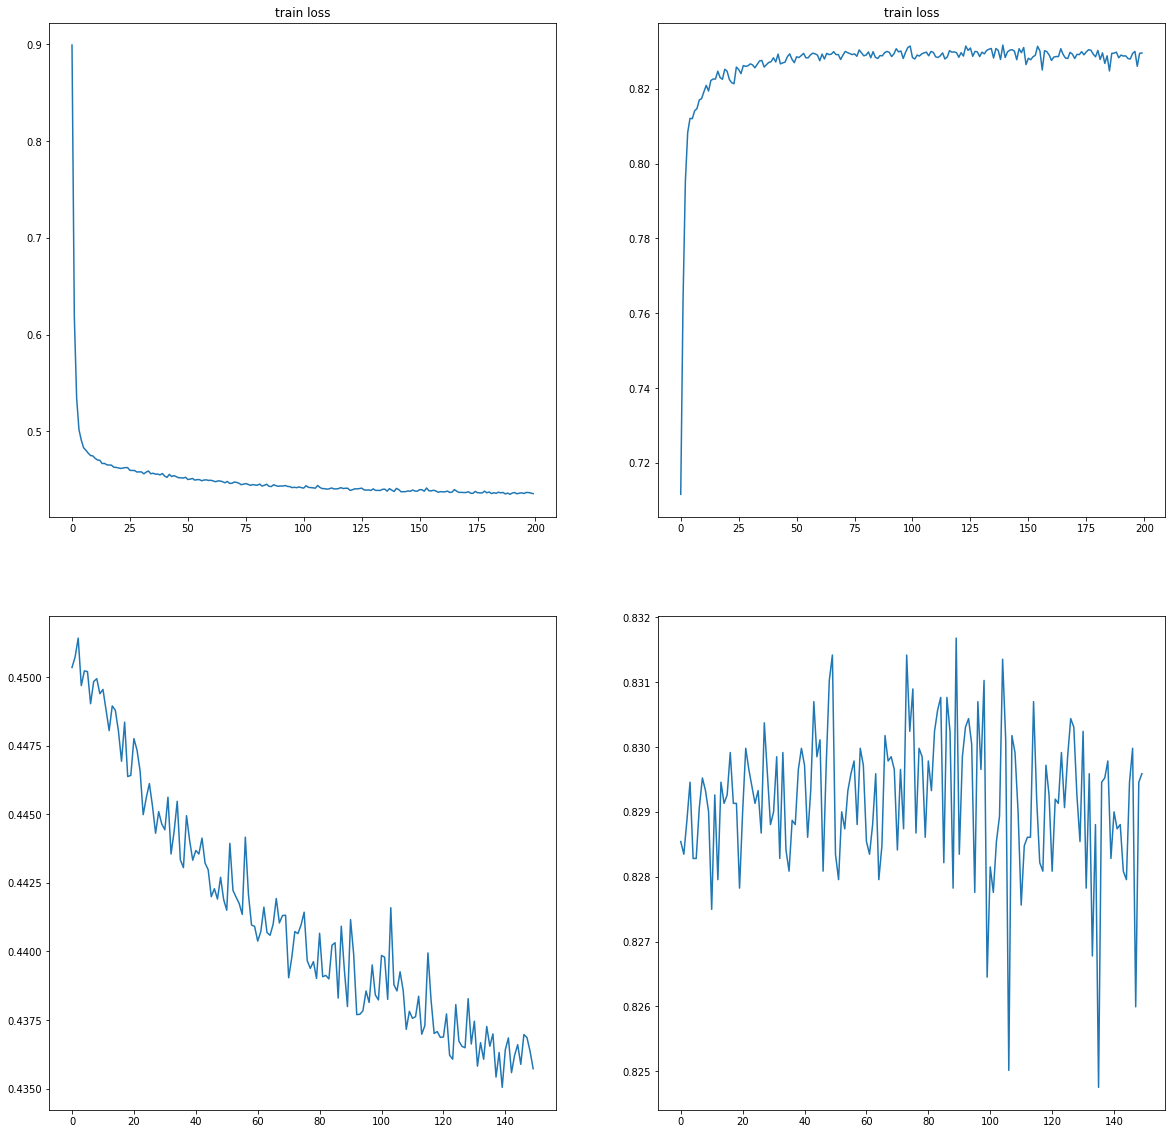

In [50]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.plot(train_loss)
plt.title('train loss')

plt.subplot(2, 2, 2)
plt.plot(val_acc)
plt.title('train loss')

plt.subplot(2, 2, 3)
plt.plot(train_loss[50:])

plt.subplot(2, 2, 4)
plt.plot(val_acc[50:])

In [52]:
np.mean(val_acc[50:])

0.82917712144973

### tabnet

In [51]:
import torch
from pytorch_tabnet.tab_model import TabNetRegressor

In [59]:
from pytorch_tabnet.tab_model import TabNetClassifier

In [53]:
cat_idxs = [i for i, c in enumerate(ori_all_feats) if c in set(ori_cat_feats)]

In [54]:
cat_idxs

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20]

In [55]:
cat_dims = [train_df[c].max() + 1 for i, c in enumerate(ori_all_feats) if c in set(ori_cat_feats)]

In [56]:
cat_dims

[6, 24, 8, 23, 2, 22, 19, 37, 41, 45, 58, 2, 2, 2, 2, 2, 2, 2]

In [64]:
X_train = train_df.loc[trn_idx, ori_all_feats].values
y_train = train_df.loc[trn_idx, label]
X_valid = train_df.loc[val_idx, ori_all_feats].values
y_valid = train_df.loc[val_idx, label]

In [58]:
X_train.shape, X_valid.shape

((61214, 36), (15304, 36))

In [61]:
# Network parameters
max_epochs = 100
batch_size = 1280
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=[4] * len(cat_idxs),
                       lambda_sparse=0.0,
                       optimizer_fn=torch.optim.Adam, # Any optimizer works here
                       optimizer_params=dict(lr=2e-2),
                       scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                       scheduler_params={"is_batch_level":True,
                                         "max_lr":5e-2,
                                         "steps_per_epoch":int(X_train.shape[0] / batch_size)+1,
                                         "epochs":max_epochs
                                          },
                       mask_type='entmax', # "sparsemax",
                      )

/usr/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [75]:
X_train.shape

(61214, 36)

In [76]:
y_train.shape

(61214,)

In [ ]:
%%time

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_valid, y_valid)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=max_epochs , patience=0,
    batch_size=batch_size,
    virtual_batch_size=128,
    num_workers=0,
    # weights=1,
    drop_last=False,
    # loss_fn=my_loss_fn
) 


/usr/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.08899 | val_accuracy: 0.431   |  0:00:05s
epoch 1  | loss: 0.8405  | val_accuracy: 0.58155 |  0:00:11s
epoch 2  | loss: 0.69544 | val_accuracy: 0.70714 |  0:00:16s
epoch 3  | loss: 0.62103 | val_accuracy: 0.75333 |  0:00:22s
epoch 4  | loss: 0.58231 | val_accuracy: 0.76359 |  0:00:28s
epoch 5  | loss: 0.55985 | val_accuracy: 0.77993 |  0:00:33s
epoch 6  | loss: 0.53906 | val_accuracy: 0.7928  |  0:00:39s
epoch 7  | loss: 0.51638 | val_accuracy: 0.80489 |  0:00:45s
epoch 8  | loss: 0.49487 | val_accuracy: 0.81436 |  0:00:50s
epoch 9  | loss: 0.48449 | val_accuracy: 0.81521 |  0:01:00s
epoch 10 | loss: 0.47941 | val_accuracy: 0.81515 |  0:01:05s
epoch 11 | loss: 0.47558 | val_accuracy: 0.81848 |  0:01:12s
epoch 12 | loss: 0.47321 | val_accuracy: 0.82116 |  0:01:17s
epoch 13 | loss: 0.46916 | val_accuracy: 0.81946 |  0:01:23s
epoch 14 | loss: 0.46892 | val_accuracy: 0.81939 |  0:01:28s
epoch 15 | loss: 0.46505 | val_accuracy: 0.8192  |  0:01:34s
epoch 16 | loss: 0.46258

In [68]:
train_loss = np.array(clf.history['loss'])
val_acc = np.array(clf.history['val_accuracy'])

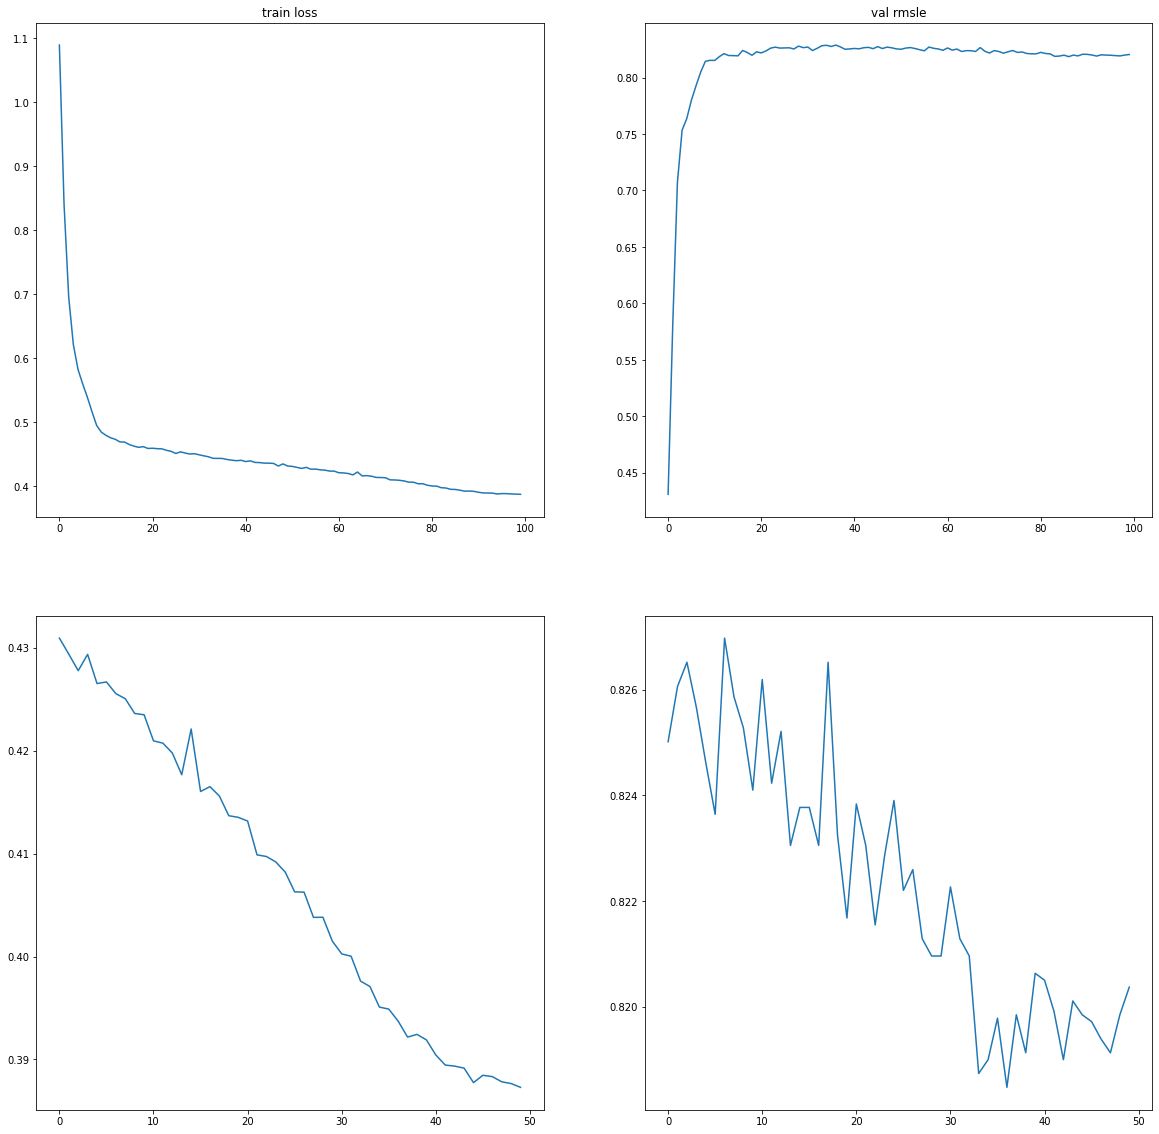

In [69]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.plot(train_loss)
plt.title('train loss')

plt.subplot(2, 2, 2)
plt.plot(val_acc)
plt.title('val rmsle')

plt.subplot(2, 2, 3)
plt.plot(train_loss[50:])

plt.subplot(2, 2, 4)
plt.plot(val_acc[50:])

In [72]:
val_acc[20:40].mean()

0.8261728959749085

#### tabnet调参

python3 bayesHyperTuning.py tn